In [8]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

### Distribution of target variable ###

There are 10.049% target values with 1


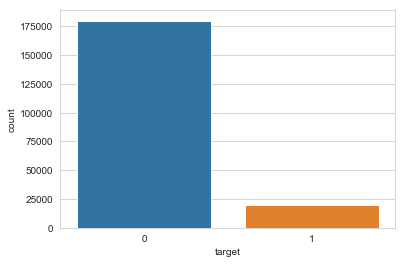

In [13]:
sns.countplot(train_df['target'])
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

### Missing Data ###

In [4]:
def missing(dataset):
    missing_count = dataset.isnull().sum()
    missing_percent = dataset.isnull().sum() / dataset.isnull().count() * 100
    totals = pd.concat([missing_count, missing_percent], axis = 1, keys = ['Count', 'Percent'])
    tys = [str(dataset[each].dtype) for each in dataset]
    totals['Types'] = tys
       
    return np.transpose(totals)

missing(train_df)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [5]:
missing(test_df)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


### Numerical data check ###

In [6]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [7]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


### Plot the scatter plot for train and test set for few of the features ###

<Figure size 432x288 with 0 Axes>

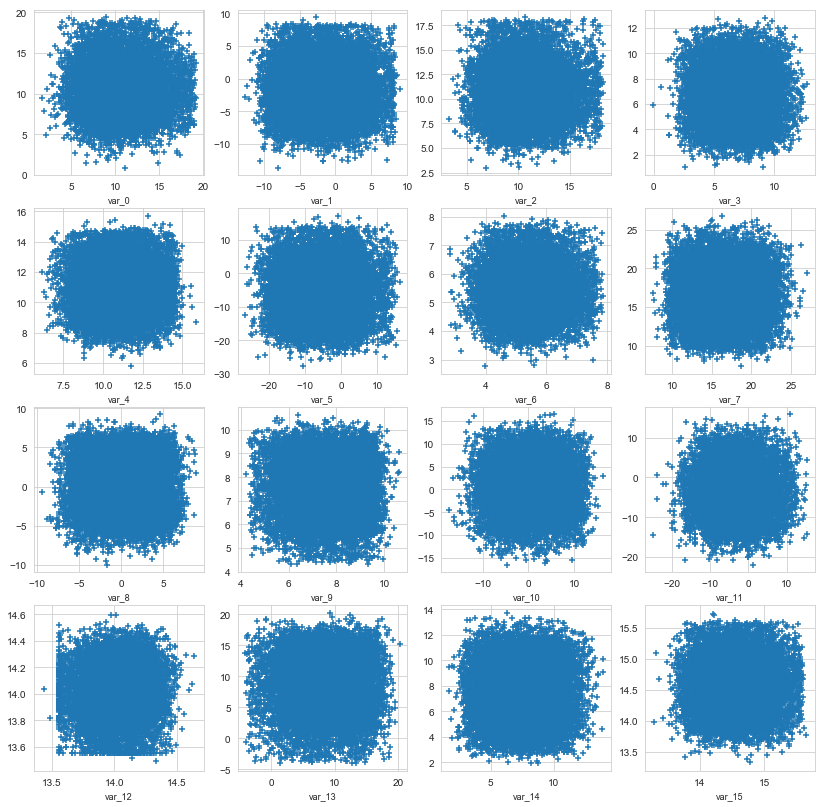

In [11]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4, 4, figsize=(14, 14))
    
    for feature in features:
        i += 1
        plt.subplot(4, 4, i)
        plt.scatter(df1[feature], df2[feature], marker = '+')
        plt.xlabel(feature, fontsize=9)
    
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

### Density plot of features in Train set ###

<Figure size 432x288 with 0 Axes>

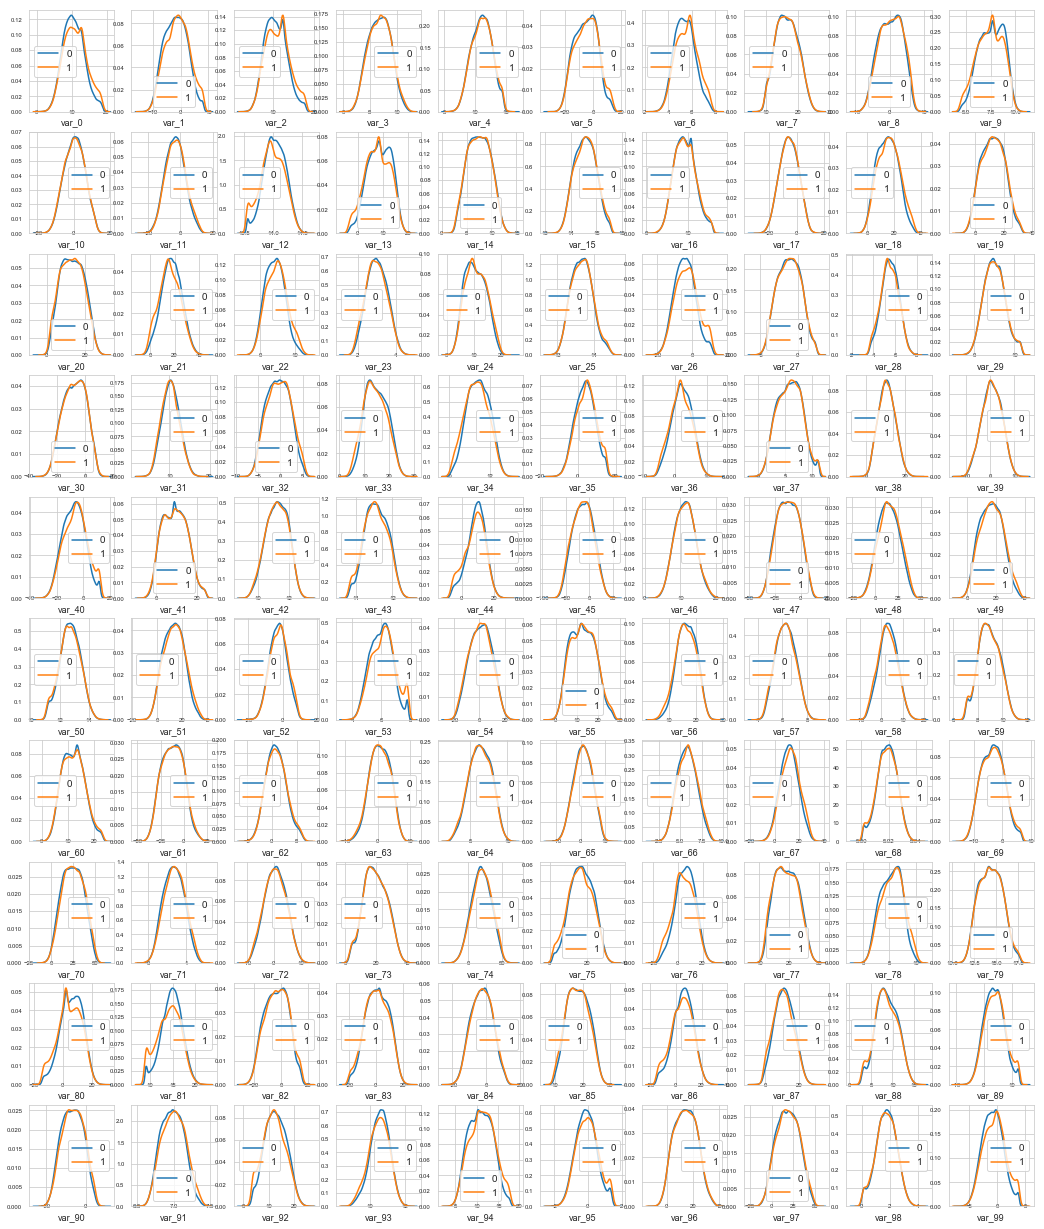

In [32]:
def plot_feature_distribution(df1, df2, label1, label2, features, nrow=10, ncol=10):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow, ncol, figsize=(18, 22))

    for feature in features:
        i += 1
        plt.subplot(nrow, ncol, i)
        sns.distplot(df1[feature], hist=False, label=label1)
        sns.distplot(df2[feature], hist=False, label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)


# t0 = train_df.loc[train_df['target'] == 0]
# t1 = train_df.loc[train_df['target'] == 1]
# features = train_df.columns.values[2:102]
# plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

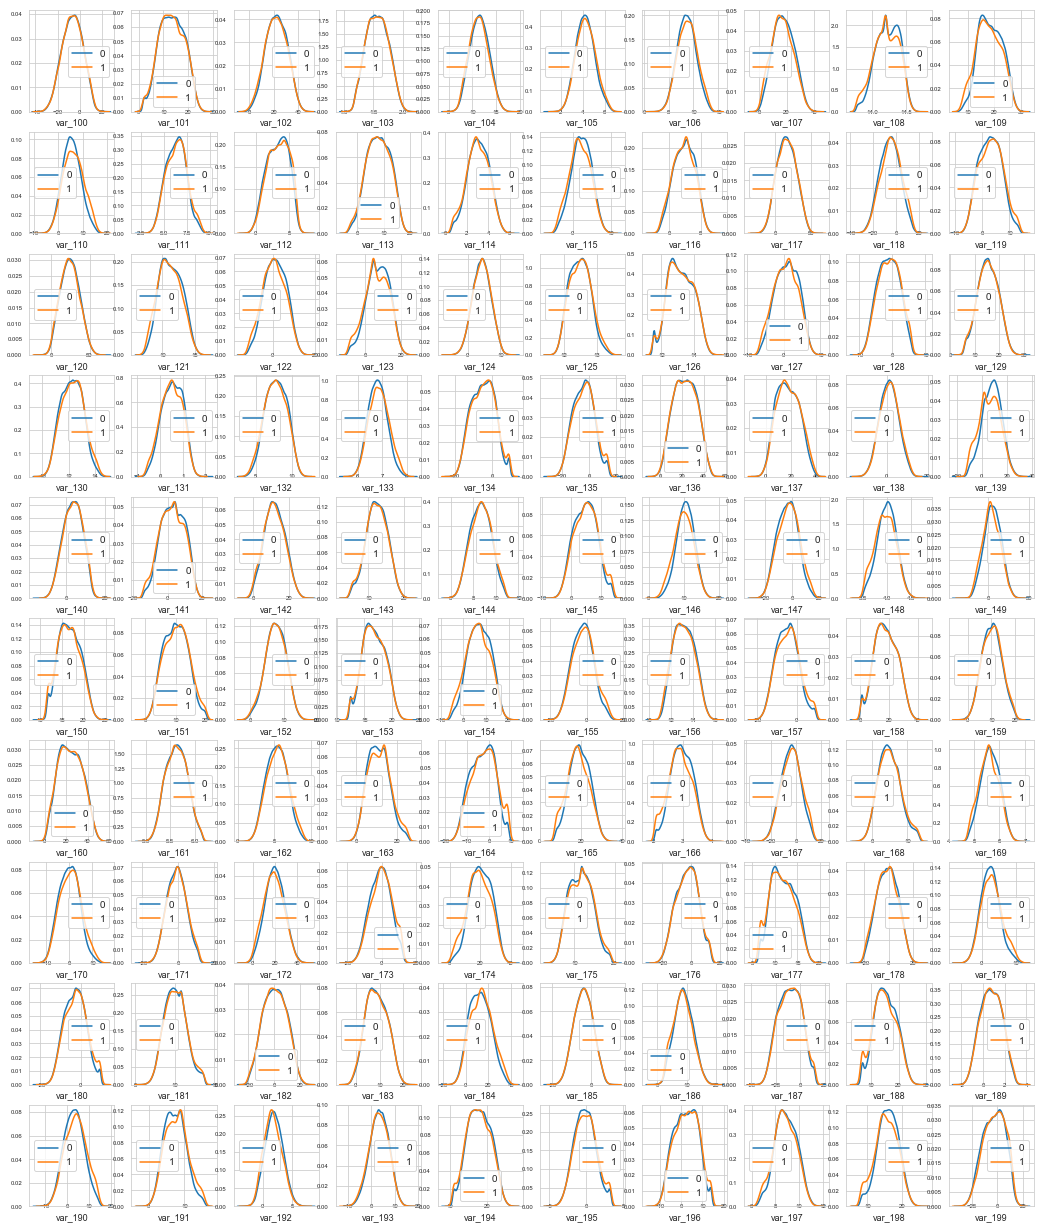

In [17]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

### Features correlations ###

In [25]:
def correlation(df, features):
    correlations = train_df[features].corr().abs().unstack().sort_values(
        kind='quicksort', ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']].loc[::2]
    return correlations

correlations = correlation(train_df, train_df.columns[2:])
correlations

,level_0,level_1,0
200,var_139,var_26,9.844361e-03
202,var_148,var_53,9.787532e-03
204,var_165,var_81,9.713658e-03
206,var_81,var_174,9.489853e-03
208,var_189,var_183,9.358682e-03
210,var_169,var_146,9.071145e-03
212,var_6,var_80,8.957933e-03
214,var_132,var_122,8.955845e-03
216,var_81,var_172,8.936047e-03
218,var_80,var_1,8.854589e-03


### Duplicated  Values ###

In [26]:
def duplicate(df, features):
    unique_max = []
    for feature in features:
        values = df[feature].value_counts()
        unique_max.append([feature, values.max(), values.idxmax()])

    return np.transpose(pd.DataFrame(unique_max, columns=['Feature', 'Max duplicate', 'Value']). \
                        sort_values(by='Max duplicate', ascending=False))

features = train_df.columns[2:202]
unique_max_train = duplicate(train_df, features)
unique_max_test = duplicate(test_df, features)
unique_max_train

,68,108,126,12,91,103,148,71,161,25,...,70,74,90,96,120,199,61,187,30,136
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,...,var_70,var_74,var_90,var_96,var_120,var_199,var_61,var_187,var_30,var_136
Max duplicate,1084,313,305,203,66,61,59,54,52,41,...,7,7,7,7,7,7,6,6,6,6
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,...,25.4822,25.6287,-15.9328,12.5468,23.1806,1.9261,-7.6718,-2.9079,-13.3689,16.1478


In [27]:
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

<Figure size 432x288 with 0 Axes>

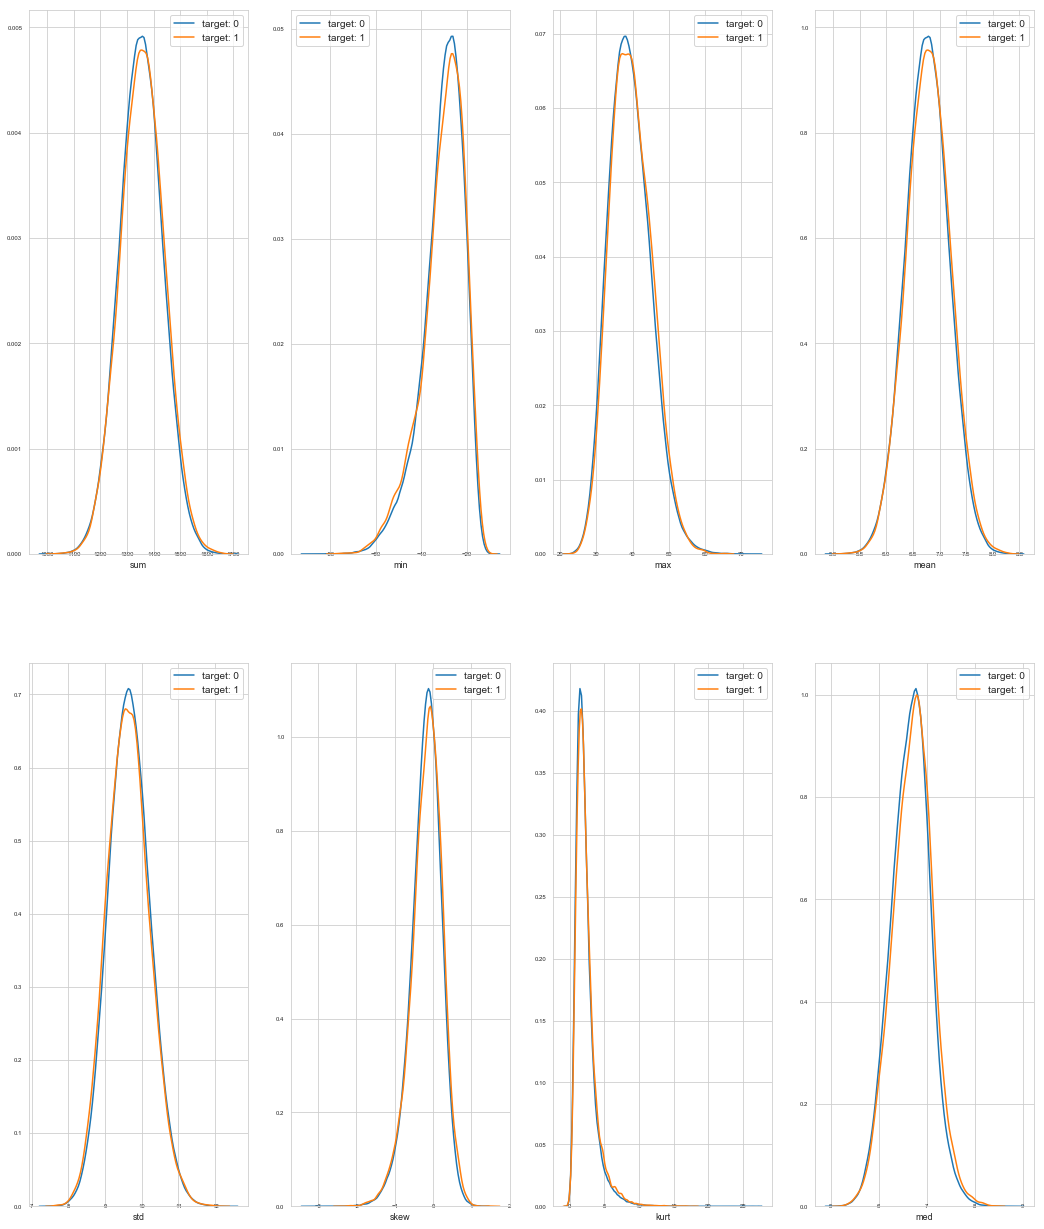

In [33]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_feature_distribution(t0, t1, 'target: 0', 'target: 1', features, 2, 4)

<Figure size 432x288 with 0 Axes>

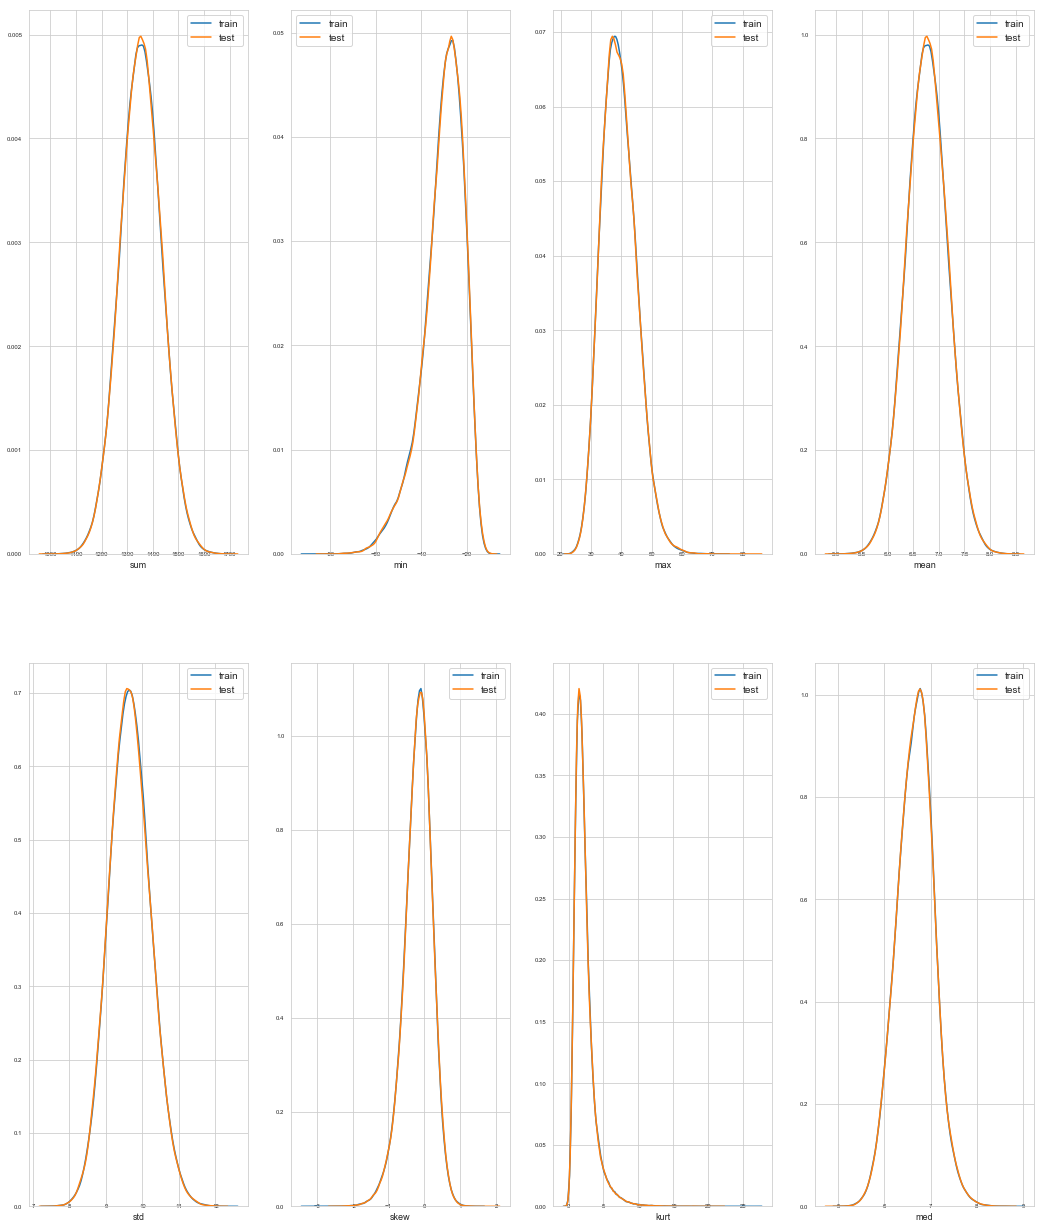

In [34]:
features = train_df.columns.values[202:]
plot_feature_distribution(train_df, test_df, 'train', 'test', features, 2, 4)

In [51]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

Train and test columns: 210 209


### Models ###

In [36]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [37]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [38]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900229	valid_1's auc: 0.881617
[2000]	training's auc: 0.91128	valid_1's auc: 0.889429
[3000]	training's auc: 0.918765	valid_1's auc: 0.893439
[4000]	training's auc: 0.924616	valid_1's auc: 0.895931
[5000]	training's auc: 0.929592	valid_1's auc: 0.897636
[6000]	training's auc: 0.933838	valid_1's auc: 0.898786
[7000]	training's auc: 0.937858	valid_1's auc: 0.899318
[8000]	training's auc: 0.941557	valid_1's auc: 0.899733
[9000]	training's auc: 0.94517	valid_1's auc: 0.899901
[10000]	training's auc: 0.948529	valid_1's auc: 0.900143
[11000]	training's auc: 0.951807	valid_1's auc: 0.900281
[12000]	training's auc: 0.954903	valid_1's auc: 0.900269
[13000]	training's auc: 0.957815	valid_1's auc: 0.900107
[14000]	training's auc: 0.960655	valid_1's auc: 0.89994
Early stopping, best iteration is:
[11603]	training's auc: 0.953681	valid_1's auc: 0.900347
Fold 1
Training until validation scores don't impro

In [39]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission2.csv", index=False)

In [45]:
def encode_FE(df, col, test):
    cv = df[col].value_counts()
    name = col + '_FE'
    df[name] = df[col].map(cv)
    test[name] = test[col].map(cv)
    test[name].fillna(0, inplace=True)
    
    if cv.max() < 255:
        df[name] = df[name].astype('uint8')
        test[name] = test[name].astype('uint8')
    else:
        df[name] = df[name].astype('uint16')
        test[name] = test[name].astype('uint16')
    return 

In [46]:
train = train_df.copy()
test = test_df.copy()
test['target'] = -1
combination = pd.concat([train, test], axis=0,sort=True)
for i in range(200):
    encode_FE(combination, 'var_' + str(i), test)
train = combination[:len(train)]

In [53]:
len(train_df.columns.tolist())

210

In [54]:
len(train.columns.tolist())

410

In [56]:
len(test_df.columns)

209

In [55]:
len(test.columns.tolist())

410

In [57]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [60]:
train_dff = train[features]
test_dff = test[features]

In [63]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_dff))
predictions = np.zeros(len(test_dff))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_dff.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_dff.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_dff.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_dff.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_dff[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.899522	valid_1's auc: 0.880355
[2000]	training's auc: 0.912624	valid_1's auc: 0.889966
[3000]	training's auc: 0.921017	valid_1's auc: 0.894351
[4000]	training's auc: 0.927537	valid_1's auc: 0.897641
[5000]	training's auc: 0.932798	valid_1's auc: 0.899389
[6000]	training's auc: 0.937654	valid_1's auc: 0.900681
[7000]	training's auc: 0.942053	valid_1's auc: 0.901483
[8000]	training's auc: 0.946103	valid_1's auc: 0.901912
[9000]	training's auc: 0.94988	valid_1's auc: 0.902136
[10000]	training's auc: 0.953442	valid_1's auc: 0.90242
[11000]	training's auc: 0.956866	valid_1's auc: 0.902456
[12000]	training's auc: 0.960093	valid_1's auc: 0.902568
[13000]	training's auc: 0.963151	valid_1's auc: 0.90267
[14000]	training's auc: 0.966041	valid_1's auc: 0.902755
[15000]	training's auc: 0.968775	valid_1's auc: 0.902855
[16000]	training's auc: 0.971325	valid_1's auc: 0.902856
[17000]	training's auc: 0.973

In [64]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)